# Simple, efficient and comprehensive housing prices analysis

On this notebook, a simple and efficient model for predicting housing prices is done, going through the following steps:
* Exploratory data analysis: Looking at target value (SalePrice) and more important features.
* Feature Engineering: treating missing data, outliers, generating new features, encoding data.
* Simple and efficient Model to predict prices: Reaching high accuracy, low RMSE, avoiding overfitting, and keeping it simple (only one parameter tuning).

I will justify each of the important steps I make, so the notebook works as a comprehensive guideline. 

In [1]:
#Import important libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#read the csv train file
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis (EDA)

Let's start by getting a sense of the dataset available, looking at the shape of the target value (SalePrice), and which numerical parameters have the the strongest correlation with it.

In [3]:
#get a quick statistical description of the target value
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

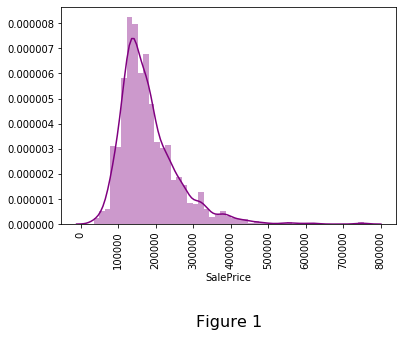

In [4]:
k=1
#check the distribution
sns.distplot(train['SalePrice'], color = 'purple')
plt.xticks(rotation=90);
plt.title('Figure {}'.format(k), y=-0.5, fontsize = 16)
k=k+1

It can be seen that SalePrice has a positive skewness and high peakness, so it doesn't follow a normal distribution. We will attend this matter later.

## Important attributes
Looking at the dataset, there are various attributes that I might expect to have a notable impact on the sale price: Above ground living area square feet (GrLivArea), the overall quality (OverallQual), the year it was built (YearBuilt), and so on... 

Let's plot some of these attributes against the target value (SalePrice) and have a quick glampse at the trends. 

Notice that by previously using the "describe" function, we can see the max value and
set a proper "ylim" value to ensure a proper visibility of every test point

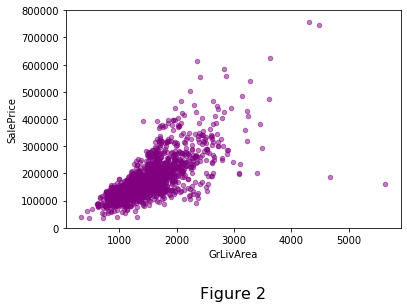

In [5]:
train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000), c ='purple',alpha = 0.5);

plt.title('Figure {}'.format(k), y=-0.35, fontsize = 16)
k=k+1

On the previous figure it can be seen there are a couple of outliers that should be taken care of...more on that later.

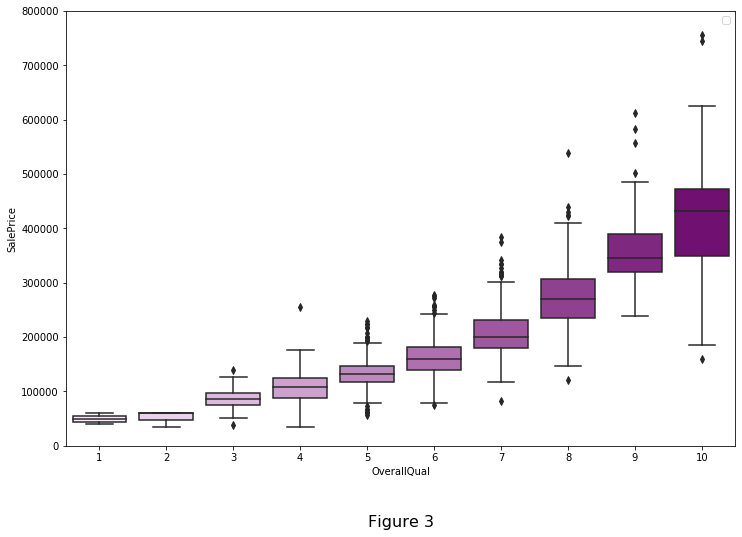

In [6]:

f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x='OverallQual', y="SalePrice",hue='OverallQual', data=train, color = 'purple',dodge=False)
fig.legend('')
fig.axis(ymin=0, ymax=800000);
plt.title('Figure {}'.format(k), y=-0.2, fontsize = 16)
k=k+1

As expected, the price increases as the size and quality of the house gets higher. 

### Correlation Matrix

We could go on to plot each possible parameter against the SalePrice. However, it is more productive to check which have the largest influence and then have a look of the most important, all at once. Then, a detailed analysis can be done on whichever parameter we are interested in.

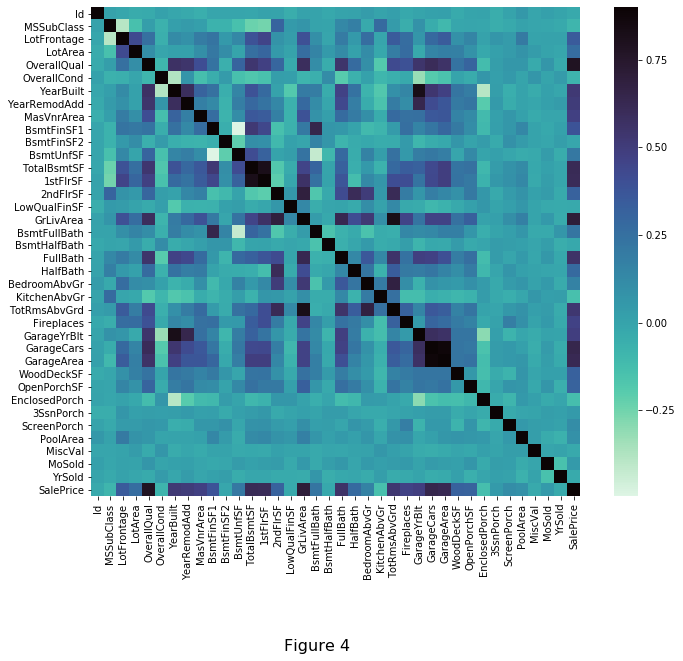

In [7]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'mako_r');
heatm.text(15, 50, 'Figure {}'.format(k),fontsize=16)
k=k+1


It can be seen (last row) that every parameter has a positive (or slightly negative at most) correlation with SalePrice. Apart from this, the matrix is too overcrowded to easily grab useful data. Thus, let's make a correlation matrix with only the parameters that have the largest correlation with the target value

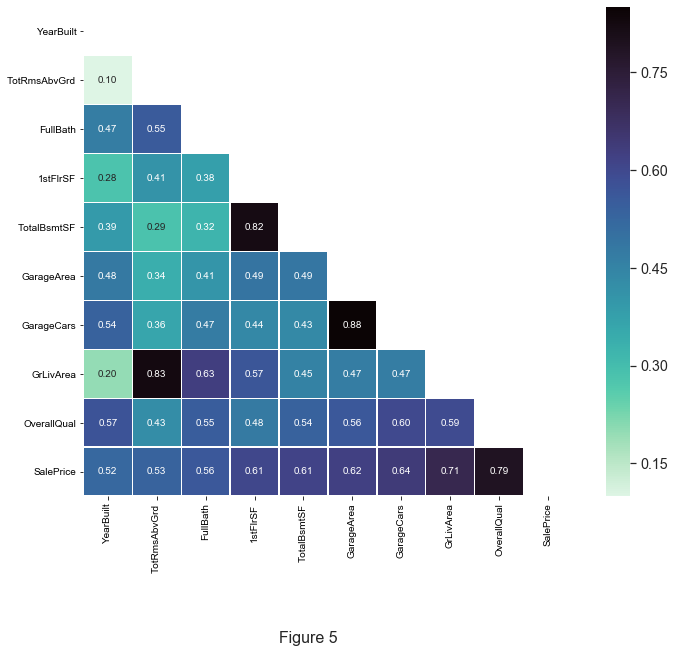

In [8]:
#saleprice correlation matrix
n = 10 #number of parameters for heatmap
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
cols2 = np.array(list(reversed(cols)))
cm = train[cols2].corr()
# mask to get only the upper triangle of the matrix, as the lower one is just repeated information
mask = np.triu(np.ones_like(cm, dtype=np.bool))
# adjust mask and df

cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'mako_r', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)
heatmap.text(4, 13, 'Figure {}'.format(k),fontsize=16)
k=k+1



Surprisingly, "YearBuilt" bearly makes the cut, so I plotted this feature to visually confirm the trend.

Indeed, the price increases for newer houses, although it does not have an impact as noticeable as I would have imagined:

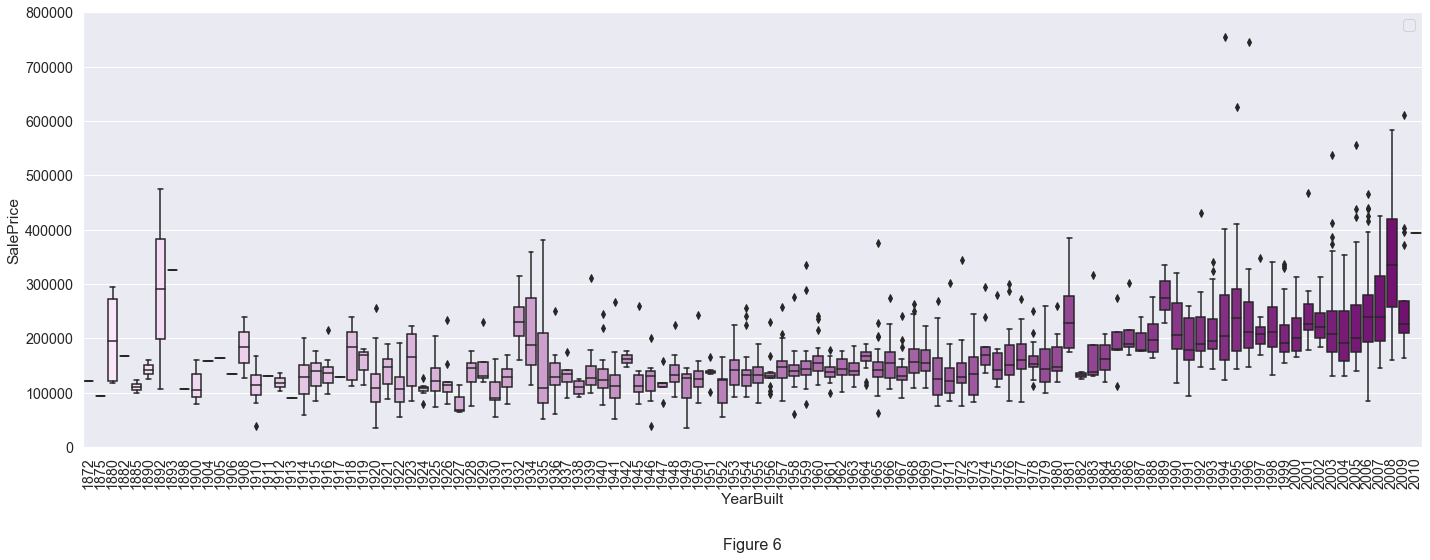

In [9]:

f, ax = plt.subplots(figsize=(24, 8))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", hue='YearBuilt', data=train, color = 'purple',dodge=False)
fig.legend('')
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);
plt.title('Figure {}'.format(k), y=-0.25, fontsize = 16)
k=k+1

Now, we can create a plot showing the trends between these variables. However, it is not necessary to plot them all, as there are three pairs highly (and logically) correlated:

-GrLivArea and TotRmsAbvGrd

-garageCars and GarageArea

-TotalBsmtSF and 1stFlrSF

So we only take one of each pair.

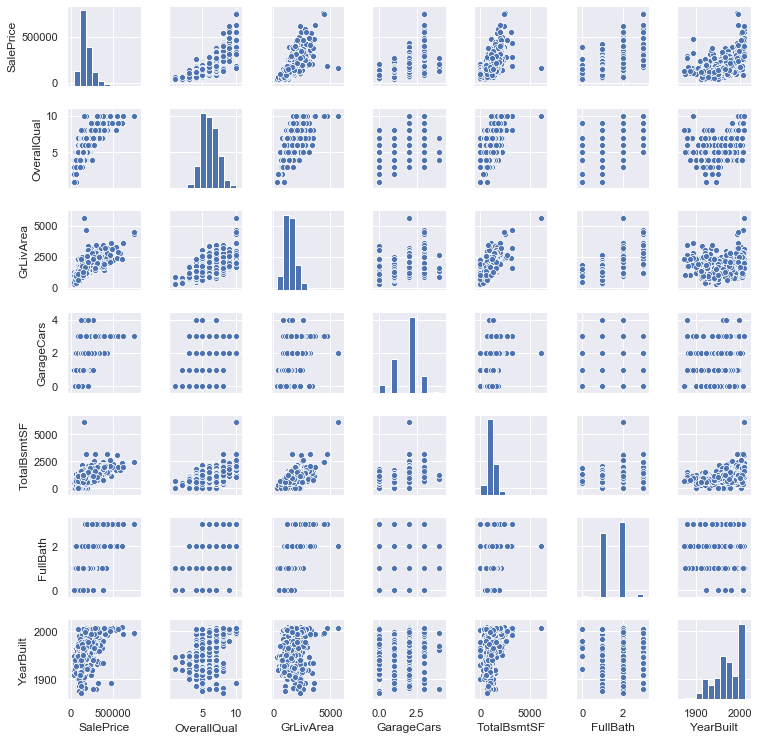

In [10]:
#seaborn pairplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
pairp = sns.pairplot(train[cols], size = 1.5, )
plt.show();

So there it is! we have quickly grasp a basic idea of the target value and how it is related to the most important numerical parameters. This exploratory data analysis is important and could be the main objective on its own.

Nevertheless, we are going to continue and dive deeper into the dataset: have a look a the missing data and how to deal with it, take into account the categorical variables that were not considered in the correlation process, and train a model to predict the final SalePrice of a house.

Let's go!

# Feature Engineering

### Missing data

In [11]:
#measuring missing data
total = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Guided by the documentation, we can fill the missing values.

**important: We shouldn't drop the categorical features with missing values, since its relation with the target value is not measured by the pearson correlation (this only measure relation between numeric features). Hence, we shouldn't assume they are not important.**

#### Loading the test set

we can now load the test file to apply the same transformation on both dataset

**Important**: note that we are never merging nor using the test data to model the evaluation method, as that would lead to data leakage. We are simply applying the same transformation to each dataset with a ***for*** loop, to avoid coding twice.

In [12]:
test = pd.read_csv('test.csv')

In [13]:
for dataset in (train, test):
    #NA means 'none' for these categorical values
    for parameter in ("PoolQC","MiscFeature","Alley","Fence","FireplaceQu",
                      'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2',"MasVnrType",'MSSubClass'):
        dataset[parameter] = dataset[parameter].fillna("None")
       
    #Basement and garage numerical missing values means non-existent, so 
    #can be filled with zeroes
    for parameter in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1',
                      'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
                      'BsmtHalfBath', "MasVnrArea"):
        dataset[parameter] = dataset[parameter].fillna(0)
    
    #categorical with very few missing values can be filled with the most frequent value:
    for parameter in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd',
                     'SaleType','Utilities'):
        dataset[parameter] = dataset[parameter].fillna(dataset[parameter].mode()[0])
    
    #data description says NA means typical
    dataset['Functional'] = dataset["Functional"].fillna("Typ")
    
    #Fill area of street with the median of the area of the street of the houses
    #in the same neighborhood
    dataset["LotFrontage"] =dataset.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [14]:
#check for any missing values
train.isnull().sum().max()

0

In [15]:
test.isnull().sum().max()

0

Now let's take care of the two outliers identified at the beginning

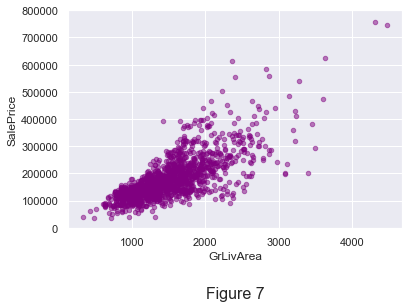

In [16]:
train.drop(train[train.GrLivArea > 4500].index, inplace = True)
train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000), c ='purple',alpha = 0.5);
plt.title('Figure {}'.format(k), y=-0.35, fontsize = 16)
k=k+1

Now, let's add a new feature which I think could help summarize an important metric: the total area of the house.

In [17]:
for dataset in (train, test):
    dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

### Log Transformations

Remember from Figure 1, that the target value presented positive skewness and high peakness (kurtosis)? This is a problem since it means the parameter doesn't follow a normal distribution, and much of the calculations we will make assume we are working with a normal distribution. Luckily, we can solve this problem by applying a logarithm transformation to the values, is positive/right skewed.

More info at: https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55


In [18]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.881296
Kurtosis: 6.523067


We can confirm it by comparing it with a normal distribution:

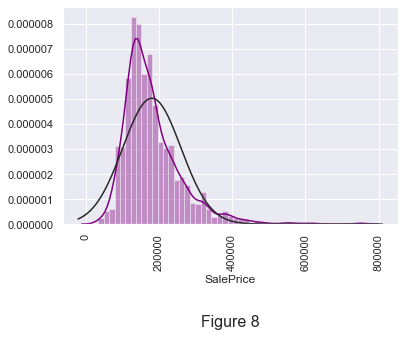

In [19]:
sns.distplot(train['SalePrice'], color= 'purple',fit=norm);
plt.xticks(rotation=90);
plt.title('Figure {}'.format(k), y=-0.5, fontsize = 16)
k=k+1

In [20]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

Skewness: 0.121568
Kurtosis: 0.804764


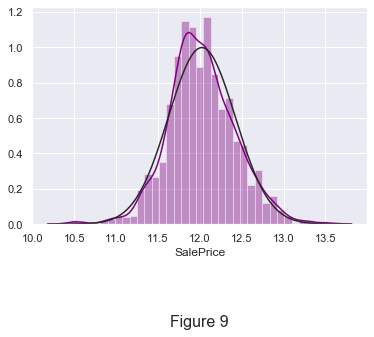

In [21]:
sns.distplot(train['SalePrice'], color= 'purple', fit=norm);
plt.title('Figure {}'.format(k), y=-0.5, fontsize = 16)
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Much better now! It will help to make the same process for every other skewed feature:

In [22]:
    #Get numerical columns
    num_data = train.dtypes[train.dtypes != "object"].index
    # Check the skew of all numerical features
    skewed_data = train[num_data].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_data})
    skewness.head(10)
    posSkew = skewness[skewness['Skew'] > 0.75]
    print("There are {} skewed numerical features to log-transform".format(posSkew.shape[0]))
    posSkew

There are 21 skewed numerical features to log-transform


,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


In [23]:
#Make a list of skewed features
skewed_feat= list(posSkew.index)

In [24]:
#Apply logarithm transformation
for dataset in (train, test):
    
    for parameter in skewed_feat:
        dataset[parameter] = np.log1p(dataset[parameter])

## Encoding

For machine learning, I always recommend OneHotEncoder (OHE) over get_dummies. We could be fine using get_dummies only if we are doing a quick exploratory data analysis. For deeper analysis, OHE does the same things as get dummies but in addition, OHE saves the exploded categories into its object. Saving exploded categories is extremely useful when you want to apply the same data pre-processing on future test sets, which may have new or missing values when compared to the train data.

For the kaggle test set there might not be any problem using get_dummies if there are no new values in this particular test set. However, in real world it's ideal to prepare for dataset with poorer quality, and OHE makes the code more robust.

More info at: https://albertum.medium.com/preprocessing-onehotencoder-vs-pandas-get-dummies-3de1f3d77dcc

In [25]:
#Assure the same order of columns in the test and train datasets

test = test[train.drop('SalePrice', axis = 1).columns]

In [26]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
#Get the categorical columns
train_object = train.select_dtypes('object')
test_object = test.select_dtypes('object')
string_column_names = list(train_object.columns)
#Fit the OneHotEncoder with the train data
ohe.fit(train_object)
#Transform categorical data and store them in separate arrays
train_encoded = ohe.transform(train_object).toarray()
test_encoded = ohe.transform(test_object).toarray()
feature_names = ohe.get_feature_names(string_column_names)
#Get numerical data from the dataset
train_num = train.select_dtypes(exclude='object')
train_num = train_num.reset_index(drop=True)
test_num = test.select_dtypes(exclude='object')
test_num = test_num.reset_index(drop=True)
#Create Dataframe with encoded data
train_converted =pd.DataFrame(train_encoded,columns=feature_names).astype(int)
train_converted = train_converted.reset_index(drop=True)
test_converted =pd.DataFrame(test_encoded,columns=feature_names).astype(int)
test_converted = test_converted.reset_index(drop=True)
#Merge original numerical data with new encoded data, for each dataset
train = pd.concat([train_num, train_converted], axis=1)
test = pd.concat([test_num, test_converted], axis=1)

# Modelling

We'll try keep it simple and efficient.

It is possible to produce a greatly developed model that iterates 10.000 times and is finely adjusted to (nearly) perfectly predict the kaggle test data, and set you on the top 1% of the leaderboard. There are various good notebooks available that employ does models, although some of them don't explain their reasoning on choosing this overcomplicated models.

However, I think it's more valuable to have a simpler model that you can understand and explain, and still produce some great predictions. Furthermore, you can get fairly good results without too much CPU requirements.

For this particular dataset I chose the Lasso linear regression, as L1 penalization bodes well when there are few medium/large effect features, which I think is the case on this dataset.

In [27]:
#Prepare train and test data for modelling
y = train["SalePrice"]
X = train.drop(columns=['SalePrice','Id'])

In [28]:
#split data to test the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Scaling
For linear regressions with regularization, such as the Lasso regression model, it is important to scale the data as these models are pretty sensitive to features weights. 

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Seeking Alpha
We'll use the Alpha parameter to control how much regularization we want on our model. To do so, we'll use GridSearchCV to find the best Alpha value in terms of RMSE.

In [30]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

las = Lasso()
grid_values = {'alpha': [0.0001,0.0002,0.0004,0.0006,0.0008,0.001,0.01]}
grid_las_mse = GridSearchCV(las, param_grid = grid_values, scoring = 'neg_mean_squared_error',n_jobs = -1)
grid_las_mse.fit(X_train_scaled, y_train)

print('Grid best parameter (min. mse): ', grid_las_mse.best_params_)

Grid best parameter (min. mse):  {'alpha': 0.0004}


In [31]:

#now we employ the best alpha parameter found and check the results
from sklearn.metrics import mean_squared_error
las = Lasso( alpha = 0.0004, random_state = 0).fit(X_train_scaled,y_train)
print('Accuracy on train data: {:.4f}'.format(las.score(X_train_scaled,y_train)))
print('Accuracy on test data: {:.4f}'.format(las.score(X_test_scaled,y_test)))
print('RMSE on test data: {:.4f}'.format(math.sqrt((mean_squared_error(y_test, las.predict(X_test_scaled))))))


Accuracy on train data: 0.9391
Accuracy on test data: 0.9378
RMSE on test data: 0.1052


A close to 94% accuracy is pretty good! We can also see that a similar high accuracy value both on the train and the test data, so we should be safe from having a overfitting model. In terms of kaggle competition, we also have a low RMSE value. Now let's fit the model to the entire train dataset.

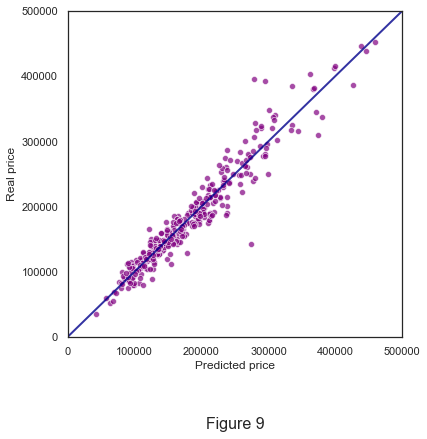

In [32]:
prediction = pd.Series(las.predict(X_test_scaled))
y_test = y_test.reset_index().drop('index', axis=1)
ytest = pd.Series(y_test['SalePrice'])
pred =pd.DataFrame({ 'Predicted price':np.exp(prediction),'Real price': np.exp(ytest)} ).reset_index()
sns.set_style("white")
#sns.scatterplot(data=pred, x="predi", y="test")
fig, axes = plt.subplots(1, 1, figsize=(6,6))
sns.scatterplot(x='Predicted price', y='Real price', data=pred, color='purple', alpha =0.7)
plt.plot([0, 600000], [0,600000], linewidth=2, c ='darkblue', alpha =0.8)
axes.set(ylim=(0, 500000),xlim=(0, 500000))

plt.title('Figure {}'.format(k), y=-0.3, fontsize = 16)
plt.rcParams["axes.labelsize"] = 20

In [33]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
las = Lasso( alpha = 0.0004, random_state = 0).fit(X_scaled,y)

In [34]:
#We Separate the ID column and scale the test data for predicting
Id = test['Id']
test = test.drop('Id',axis = 1)
test_scaled = scaler.transform(test)

In [35]:
#Preparing the submission file
resultslog = las.predict(test_scaled)
results = np.exp(resultslog)
output = pd.DataFrame({'Id': Id, 'SalePrice': results})
output

,Id,SalePrice
0,1461,119883.303157
1,1462,157391.326553
2,1463,182720.114146
3,1464,196795.800461
4,1465,196219.967915
5,1466,170325.715054
6,1467,177629.765311
7,1468,159385.736036
8,1469,198762.289053
9,1470,118492.016494


In [36]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was saved!")

Your submission was saved!


So there it is, a simple model with only one parameter tuning. Hope you got something useful out of this notebook, I would gladly hear any feedback!